## AIDI 2004 - AI in Enterprise Systems

### FINAL PROJECT

by Michael Molnar and Vasundara Chandre Gowda

Condensing long passages of text into short and representative snippets is a important task in natural language processing.  People can often be left frustrated at the end of reading an article, having found they had been fooled by a sensation, clickbait headline. 

In this project we will train and build our own deep learning model that will generate a novel summary that captures the main points of a news article, product review, or other text sample.    

We will build a web application and deploy our model for use. 

### NOTEBOOK 1:

In this notebook we will load our chosen dataset and perform an Exploratory Data Analysis on it.  Next, we will perform all of the text cleaning and pre-processing techniques required to get the data into a suitable form for modeling.  At the conclusion of this notebook we will be ready to split our data into training and test sets and begin building and training an abstractive summarization deep learning model.

### The Amazon Fine Food Reviews Dataset

This is a famous dataset for NLP projects, containing all of the reviews posted on Amazon's fine food products between October 1999 and October 2012.  The dataset contains a wealth of information for each review, which makes this dataset popular for things such as sentimental analysis and other classification tasks.  For the purposes of this project we will make use of only two columns - the review text and the review's summary.  Our goal is to build a deep learning model that will generate these summaries using an abstractive approach. 

Dataset Source:  https://snap.stanford.edu/data/web-FineFoods.html

CSV Downloaded From:  https://www.kaggle.com/snap/amazon-fine-food-reviews  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

### Loading the Data

In [2]:
# Load the dataset
df = pd.read_csv('Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
# Check the shape
df.shape

(568454, 10)

We have over 560k reviews, and a number of fields for each.  As mentioned, for the purposes of this project we will use only two columns - "Text" and "Summary".

In [4]:
# Drop the columns we will not use
df = df.drop(columns = ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
                       'HelpfulnessDenominator', 'Score', 'Time'], axis = 1)

In [5]:
# Check the info for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Summary  568427 non-null  object
 1   Text     568454 non-null  object
dtypes: object(2)
memory usage: 8.7+ MB


In [6]:
# Drop rows where there is a missing entry
df = df.dropna()

In [7]:
# Drop rows that are duplicates
df = df.drop_duplicates()

In [8]:
# Recheck the shape
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 394967 entries, 0 to 568453
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Summary  394967 non-null  object
 1   Text     394967 non-null  object
dtypes: object(2)
memory usage: 9.0+ MB


After dropping rows that are duplicates or have either a missing summary or a missing review text, we are left with 394,967 unique rows.  We will now begin our EDA on the data.

### Exploratory Data Analysis

#### Exploring the "Text" column

In [9]:
df.head()

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


In [10]:
# Count the number of words in each review text
df['Text_Words'] = df['Text'].apply(lambda x: len(str(x).split()))

In [11]:
# Get the summary statistics
df['Text_Words'].describe()

count    394967.000000
mean         79.883347
std          77.449276
min           3.000000
25%          34.000000
50%          57.000000
75%          98.000000
max        3432.000000
Name: Text_Words, dtype: float64

We see that the average review contains about 80 words.  The shortest reviews are 3 words, and the longest review is over 3400 words long.  Three quarters of all the reviews are less than 100 words.

When it comes time to build our tokenizers and our model we will be limiting reviews to be below a certain length, but for the purposes of this analysis we will explore these reviews further.

#### Examining Short Reviews

In [12]:
# Get rows where the review contains less than 5 words
df[df['Text_Words'] < 5].shape

(3, 3)

We see there are only three reviews that are shorter than five words.

In [13]:
# Get rows where the article contains less than 80 words
df[df['Text_Words'] < 80].shape

(261948, 3)

In [14]:
# Get rows where the article contains less than 50 words
df[df['Text_Words'] < 60].shape

(207259, 3)

There are over 260k reviews that are 80 words or less and over 207k reviews 50 words or less.  As mentioned, when we begin tokenizing the data and building our model, we will have to set a threshold for the length of the review, otherwise we will run into memory issues as the vocabulary becomes too large.  

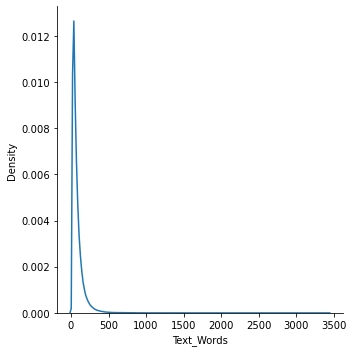

In [15]:
# Plot the review length as a density plot
sns.displot(x = 'Text_Words', data = df, kind = 'kde')

The majority of the reviews are short, though there are high outliers as mentioned.  To get a better view on this distribution, we will repeat the plot but filtering only for reviews 50 words or less.

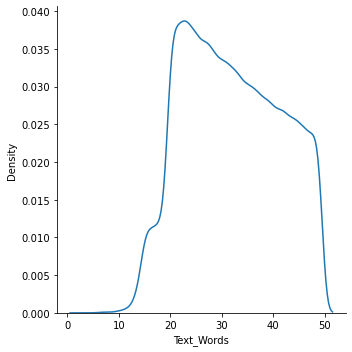

In [16]:
# Plot the review length as a density plot
sns.displot(x = 'Text_Words', data = df[df['Text_Words'] < 50], kind = 'kde')

We see from this plot that there are very few reviews less than about 12 words, and the most common length is somewhere around 25 words in length.  

#### Exploring the "Summary" column

In [17]:
# Count the number of words in each review summary
df['Summary_Words'] = df['Summary'].apply(lambda x: len(str(x).split()))

In [18]:
# Get the summary statistics
df['Summary_Words'].describe()

count    394967.000000
mean          4.090116
std           2.585658
min           1.000000
25%           2.000000
50%           3.000000
75%           5.000000
max          42.000000
Name: Summary_Words, dtype: float64

We see that the summaries are very short.  This will help our model, since it will not be required to generate excessively long summaries from scratch.  The average summary is 4 words long and three quarters of all summaries are 5 words or less.

In [19]:
# Get rows where the summary contains one word
df[df['Summary_Words'] == 1]

,Summary,Text,Text_Words,Summary_Words
21,TWIZZLERS,I bought these for my husband who is currently...,45,1
23,Twizzlers,I love this candy. After weight watchers I ha...,19,1
28,YUMMY!,I got this for my Mum who is not diabetic but ...,94,1
35,satisfying,"McCann's Instant Irish Oatmeal, Variety Pack o...",74,1
42,Food-Great,I have McCann's Oatmeal every morning and by o...,31,1
...,...,...,...,...
568418,tuffer,we just had a new lawn put in and it was very ...,47,1
568420,Co-co-yummy!,Love the coconut flavor of this tea. Two thin...,37,1
568430,delicious,This product is a bit pricey for the amt. rece...,30,1
568439,a-ok,We need this for a recipe my wife is intereste...,22,1


There are over 40k summaries that are only a single word.  This is a significant percentage of the total dataset.

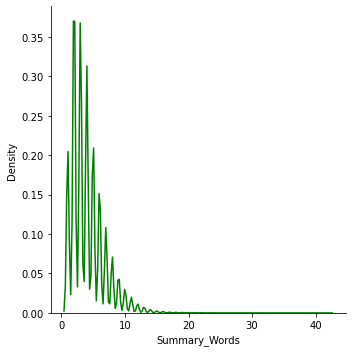

In [20]:
# Plot the summary length as a density plot
sns.displot(x = 'Summary_Words', data = df, kind = 'kde', color = 'green')

We will filter this for summaries less than or equal to 10 words to better examine the trend.

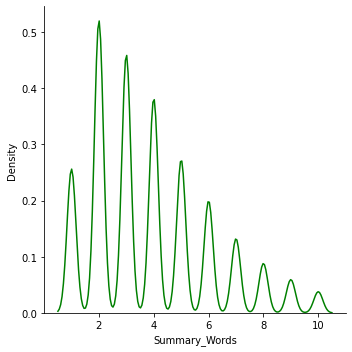

In [21]:
# Plot the summary length as a density plot
sns.displot(x = 'Summary_Words', data = df[df['Summary_Words'] <= 10], kind = 'kde', color = 'green')

We see that the most common lengths of the summaries are 2 to 4 words, with the longer summaries becoming less and less common as the number of words increases.

#### Exploring the Relationship Between Aritcle Length and Summary Length

We want to explore if the length of the review and the length of its corresponding summary are correlated.

<AxesSubplot:xlabel='Text_Words', ylabel='Summary_Words'>

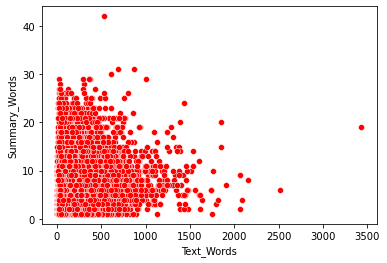

In [22]:
# Plot a scatterplot comparing review length and summary length
sns.scatterplot(x = 'Text_Words', y = 'Summary_Words', data = df, color = 'red')

What is interesting about this plot is that it appears that a lot of the shorter articles have longer summaries.  As noted previously, 75% of the reviews are under 100 words in length.  We will reproduce this plot, filtering for articles under this length.

In [23]:
# Create a dataframe containing only rows where the review text is under 100 words in length
df100 = df[df['Text_Words'] < 100]

<AxesSubplot:xlabel='Text_Words', ylabel='Summary_Words'>

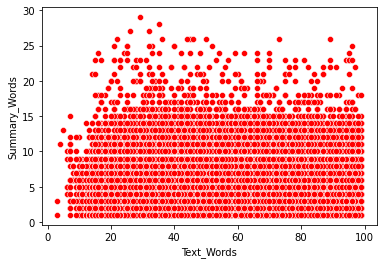

In [24]:
# Plot a scatter plot comparing review length and summary length
sns.scatterplot(x = 'Text_Words', y = 'Summary_Words', data = df100, color = 'red')

Taking this view, there doesn't actually seem to be much of a correlation at all between the review length and the summary length.

In [25]:
# Check the correlation 
df.corr()

,Text_Words,Summary_Words
Text_Words,1.000000,0.284619
Summary_Words,0.284619,1.000000


We see that the correlation is positive, but low.  As the article length increases, so does the summary length.

#### Comparing Article Review Texts to Summaries

We are going to be building an abstractive text summarization model.  To give a little bit of background, there are two techniques that are used to generate summaries of passages of text.

(Image Sources:  https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)

![Extractive Summarization](extractive.png)

In <b> extractive summarization </b> sentences are given scores based on how important they are deemed to be to the text as a whole.  Then the summary is produced by picking the most important sentences and joining them together.

![Abstractive Summarization](abstractive.png)

In <b> abstractive summarization </b> the summary is produced not by picking important sentences from the text, but by generating new sentences, from scratch, that capture the essence of the text.  

Since this is our goal, we will take a look at the summaries we have in our dataset.  Particularly we are trying to examine how unique the summaries are when compared to the text they are meant to represent.

In [26]:
# Get the first review in the dataset
sample_review = df['Text'][0].lower()
print('Sample Review:', sample_review)

Sample Review: i have bought several of the vitality canned dog food products and have found them all to be of good quality. the product looks more like a stew than a processed meat and it smells better. my labrador is finicky and she appreciates this product better than  most.


In [27]:
# Get the first summary in the dataset
sample_summary = df['Summary'][0].lower()
print('Sample Summary:', sample_summary)

Sample Summary: good quality dog food


In [28]:
# Is the summary, considered as one sentence, contained in the review?
sample_summary in sample_review

False

In [29]:
# Are the individual words of the summary contained in the review?
for word in sample_summary.split():
    print(word in sample_review)

True
True
True
True


Just looking at this one example, the review contains four words, "good quality dog food".  Each of these individual words are present in the review, but the entire phrase is not.  Looking at the summary text, we can see "dog food" and we can see later, "good quality".  This is the goal of our summarization model.  We are looking to create phrases that capture the essence of the text, without merely extracting entire sentences.  We will look at one more example.

In [30]:
# Get the second review in the dataset
sample_review = df['Text'][1].lower()
print('Sample Review:', sample_review)

Sample Review: product arrived labeled as jumbo salted peanuts...the peanuts were actually small sized unsalted. not sure if this was an error or if the vendor intended to represent the product as "jumbo".


In [31]:
# Get the second summary in the dataset
sample_summary = df['Summary'][1].lower()
print('Sample Summary:', sample_summary)

Sample Summary: not as advertised


In this case we can see that the summary, "not as advertised", does not appear in the review.  Not only that, the word "advertised" doesn't appear in the review.  The summary in this case is totally novel compared to the review.  This is the way in which a human being may write a review - a short phrase that captures the key point of the text without repeating anything contained in it.

As an experiment we will perform this on every row in the dataset.  

In [32]:
# For each row, check if the summary appears in the review text
df['Summary_in_Text?'] = df.apply(lambda row: row['Summary'].lower() in row['Text'].lower(), axis = 1)

In [33]:
df

,Summary,Text,Text_Words,Summary_Words,Summary_in_Text?
0,Good Quality Dog Food,I have bought several of the Vitality canned d...,48,4,False
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,31,3,False
2,"""Delight"" says it all",This is a confection that has been around a fe...,94,4,False
3,Cough Medicine,If you are looking for the secret ingredient i...,41,2,False
4,Great taffy,Great taffy at a great price. There was a wid...,27,2,True
...,...,...,...,...,...
568449,Will not do without,Great for sesame chicken..this is a good if no...,26,4,False
568450,disappointed,I'm disappointed with the flavor. The chocolat...,46,1,True
568451,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",66,4,False
568452,Favorite Training and reward treat,These are the BEST treats for training and rew...,35,5,False


In [34]:
# Check how many rows are True
df['Summary_in_Text?'].sum()

26931

<AxesSubplot:xlabel='Summary_in_Text?', ylabel='count'>

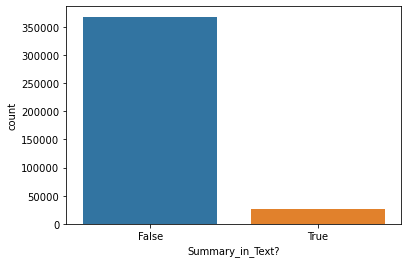

In [35]:
# Plot this as a count plot
sns.countplot(x = 'Summary_in_Text?', data = df)

We see that the vast majority of the summaries do not appear directly in the text.

#### Exploring the Most Commonly Appearing Words

We will now examine the most commonly appearing words in our text and summarise.  To do this, we will make use of the Count Vectorizer to split the text into word tokens.  We will then count the instances of each word, and then sort the list.  We will display the most commonly appearing words as a Word Cloud.

In [36]:
def n_most_common(corpus, length = 1, n = None, stop_words = None):
    """
    Returns a dictionary of the most common n words in the corpus, along with the count for each.
    The length can be made to split by words (1), bigrams (2), trigrams (3), and so on. 
    We can remove stop words by passing stop_words = 'english'.
    """
    # Fit a Count Vectorizer on the corpus
    vec = CountVectorizer(ngram_range=(length, length), stop_words=stop_words).fit(corpus)
    # Transform the corpus into individual words
    words = vec.transform(corpus)
    # Count the number of occurrences of each word
    sum_words = words.sum(axis=0) 
    # Create a list of tuples of these counts
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    # Sort this list in ascending order by count
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    # Get the top n 
    top_n = words_freq[:n]
    # Return as a dictionary for Word Cloud display
    return dict(top_n)

In [37]:
def plot_word_cloud(words_dict, color):
    """
    Take a dictionary of words and their counts and generate a Word Cloud.
    The sizes of the words will be proportional to their count.
    """
    cloud = WordCloud(background_color=color).generate_from_frequencies(words_dict)
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(cloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

#### 50 Most Common Words in the "Text"

In [38]:
review_words = n_most_common(df['Text'], n=50)

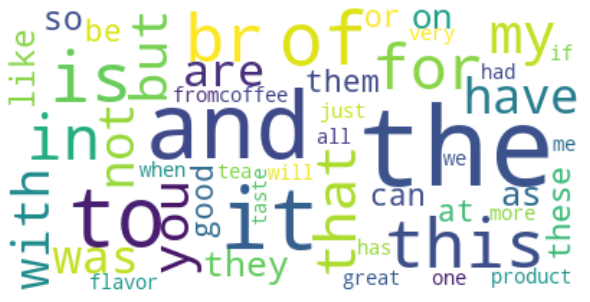

In [39]:
plot_word_cloud(review_words, 'white')

We can see that the majority of these are what are known as stopwords.  These are very common English words that generally do not add much meaning to a sentence - words like the, is, this, and, to it, and so on.  These words will all be removed as part of the data pre-processing that will take place in the next part of this project.  For now, let us repeat this same process on the summary text.

#### 50 Most Common Words in the "Summary"

In [40]:
summary_words = n_most_common(df['Summary'], n=50)

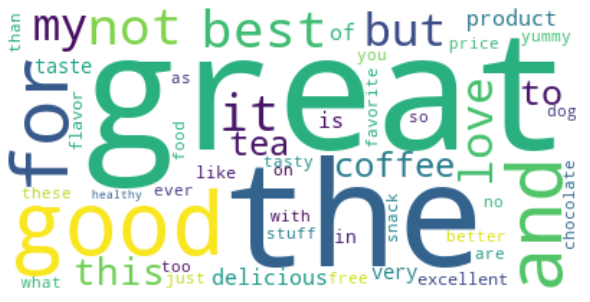

In [41]:
plot_word_cloud(summary_words, 'white')

Since the summaries are generally very short, we see there are not a lot of these stopwords present in this Word Cloud.  We will now repeat this process, removing the stopwords and seeing how the results change.

#### 50 Most Common Words in the "Text" - stopwords removed

In [42]:
review_words = n_most_common(df['Text'], n=50, stop_words='english')

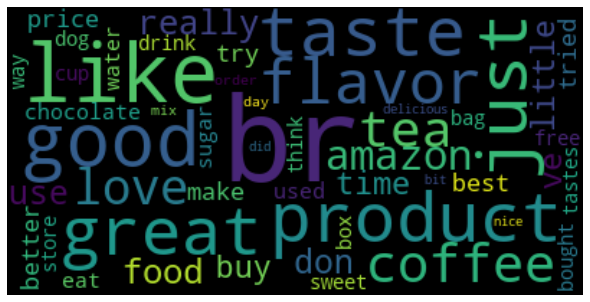

In [43]:
plot_word_cloud(review_words, 'black')

#### 50 Most Common Words in the "Summary" - stopwords removed

In [44]:
summary_words = n_most_common(df['Summary'], n=50, stop_words='english')

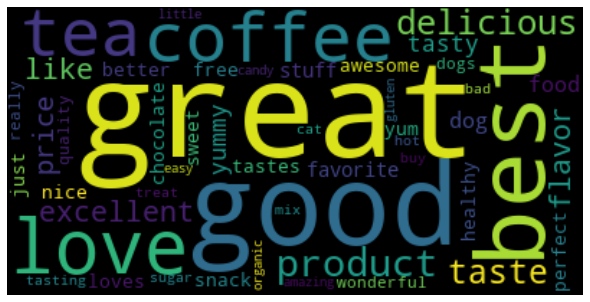

In [45]:
plot_word_cloud(summary_words, 'black')

There is some overlap here, words like "good" and "coffee" are among the most commonly appearing in both the reviews and the summaries, but there is a good variety of words in each.  

#### Counting the Number of Unique Words in the Text Column (before pre-processing)

In [46]:
# Fit a count vectorizer on the entire text column
text_vec = CountVectorizer()
text_words = text_vec.fit_transform(df['Text'])

In [58]:
# Get the number of unique words in the text column
total_text_words = len(text_vec.get_feature_names())
total_text_words

120252

#### Counting the Number of Unique Words in the Summary Column (before pre-processing)

In [59]:
# Fit a count vectorizer on the entire summary column
summary_vec = CountVectorizer()
summary_words = summary_vec.fit_transform(df['Summary'])

In [60]:
# Get the number of unique words in the summary column
total_summary_words = len(summary_vec.get_feature_names())
total_summary_words

33517

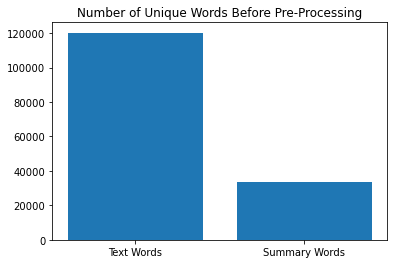

In [66]:
# Store in a dictionary
unique_words = {'Text Words': total_text_words, 
                'Summary Words': total_summary_words}
# Plot as a bar plot 
plt.bar(unique_words.keys(), unique_words.values())
plt.title('Number of Unique Words Before Pre-Processing')
plt.show()

We can see that there are a huge number of unique words in our dataset, but a large number of these will be removed through preprocessing.  We will reproduce this plot once we have performed all of the text cleaning operations.

### Concluding Thoughts on EDA

We have completed our Exploratory Data Analysis and are ready to move onto data pre-processing.  In that part of the project we will perform all of the cleaning operations that are typical in NLP projects.  This will include:
- Lowercasing all text
- Removing special characters
- Expanding contractions
- Removing non-alphabetic characters
- Removing stopwords
- Removing single character words
- Removing strings that have been made empty

We have seen that the majority of our summaries are five words or less.  We will use this knowledge to choose an appropriate threshold when building our model, so that the model will not have to predict excessively long sequences.

Once the text cleaning has been performed, we will split our data in training and testing sets, build and fit our tokenizers, and then build and train our model.  

### Data Pre-Processing

In [67]:
# Check our current dataframe
df

,Summary,Text,Text_Words,Summary_Words,Summary_in_Text?
0,Good Quality Dog Food,I have bought several of the Vitality canned d...,48,4,False
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,31,3,False
2,"""Delight"" says it all",This is a confection that has been around a fe...,94,4,False
3,Cough Medicine,If you are looking for the secret ingredient i...,41,2,False
4,Great taffy,Great taffy at a great price. There was a wid...,27,2,True
...,...,...,...,...,...
568449,Will not do without,Great for sesame chicken..this is a good if no...,26,4,False
568450,disappointed,I'm disappointed with the flavor. The chocolat...,46,1,True
568451,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",66,4,False
568452,Favorite Training and reward treat,These are the BEST treats for training and rew...,35,5,False


In [68]:
# Remove the extra columns we have created during our EDA
df = df.drop(columns = ['Text_Words', 'Summary_Words', 'Summary_in_Text?'])

We first create a dictionary of contractions and what they should be expanded to.

In [70]:
contraction_mappings = {"ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because", 
                       "could've": "could have", "couldn't": "could not", "didn't": "did not", 
                       "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", 
                       "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", 
                       "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                       "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have",
                       "I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", 
                       "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                       "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", 
                       "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", 
                       "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", 
                       "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                       "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", 
                       "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", 
                       "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", 
                       "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                       "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", 
                       "that's": "that is", "there'd": "there would", "there'd've": "there would have", 
                       "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", 
                       "they'll": "they will", "they'll've": "they will have", "they're": "they are", 
                       "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                       "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                       "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
                       "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", 
                       "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", 
                       "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", 
                       "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", 
                       "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                       "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                       "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                       "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [71]:
# Import the list of stopwords
stopwords = set(stopwords.words('english'))

We will create two cleaning functions - one for the review text and one for the summaries.  Since the summaries are all very short, we will not remove the stopwords from them.

In [72]:
def clean_text(text):
    """
    Performs all necessary cleaning operations on text input.
    """
    # Lowercase the text
    new_text = text.lower()
    # Remove special characters
    new_text = re.sub(r'\([^)]*\)', '', new_text)
    new_text = re.sub('"', '', new_text)
    # Expand contractions
    new_text = ' '.join([contraction_mappings[x] if x in contraction_mappings else x for x in new_text.split(' ')])
    # Remove 's 
    new_text = re.sub(r"'s\b", '', new_text)
    # Replace non-alphabetic characters with a space
    new_text = re.sub('[^a-zA-Z]', ' ', new_text)
    # Split the text into tokens and remove stopwords
    tokens = [word for word in new_text.split() if word not in stopwords]
    # Keep only tokens that are longer than one letter long 
    words = []
    for t in tokens:
        if len(t) > 1:
            words.append(t)
    # Return a rejoined string 
    return (' '.join(words).strip())

In [73]:
# Test this function 
text = "Hi, my name is Michael. This function's purpose is to clean text! It's working? 1-1$>!"

In [74]:
clean_text(text)

'hi name michael function purpose clean text working'

In [75]:
def clean_summary(text):
    """
    Cleans the summary text, keeping stopwords in the text.
    """
    # Lowercase the text
    new_text = text.lower()
    # Remove special characters
    new_text = re.sub(r'\([^)]*\)', '', new_text)
    new_text = re.sub('"', '', new_text)
    # Expand contractions
    new_text = ' '.join([contraction_mappings[x] if x in contraction_mappings else x for x in new_text.split(' ')])
    # Remove 's 
    new_text = re.sub(r"'s\b", '', new_text)
    # Replace non-alphabetic characters with a space
    new_text = re.sub('[^a-zA-Z]', ' ', new_text)
    # Split the text into tokens and remove stopwords
    tokens = new_text.split()
    # Keep only tokens that are longer than one letter long 
    words = []
    for t in tokens:
        if len(t) > 1:
            words.append(t)
    # Return a rejoined string 
    return (' '.join(words).strip())

In [77]:
# Test this function
clean_summary(text)

'hi my name is michael this function purpose is to clean text it is working'

We see that the two functions are working as they we intend them to.  We now apply these functions to our Text and Summary columns, creating two new columns in our dataframe in the process.

In [78]:
# Clean Text
df['cleaned_text'] = df['Text'].apply(lambda row: clean_text(row))

In [79]:
# Clean Summary
df['cleaned_summary'] = df['Summary'].apply(lambda row: clean_summary(row))

Some entries may have been made into empty strings by the cleaning functions, if they had contained only stop words, for example, or something like "A+".  For this reason, we will replace empty strings with nan values, and then drop these rows.

In [80]:
# Replace empty strings with nan
df['cleaned_text'].replace('', np.nan, inplace = True)
df['cleaned_summary'].replace('', np.nan, inplace = True)

In [81]:
# Remove rows with nan values
df.dropna(axis = 0, inplace = True)

In [82]:
# Check the new shape of the dataframe
df.shape

(394618, 4)

We see that our dataframe has gone from 394967 rows to 394618 rows.  We will now check the number of unique words appearing in our cleaned text and cleaned summary columns.

#### Counting the Number of Unique Words in the Text Column (after pre-processing)

In [83]:
# Fit a count vectorizer on the entire clean text column
clean_text_vec = CountVectorizer()
clean_text_words = clean_text_vec.fit_transform(df['cleaned_text'])

In [85]:
# Get the number of unique words in the cleaned text column
total_clean_text_words = len(clean_text_vec.get_feature_names())
total_clean_text_words

108025

#### Counting the Number of Unique Words in the Summary Column (after pre-processing)

In [86]:
# Fit a count vectorizer on the entire clean summary column
clean_summary_vec = CountVectorizer()
clean_summary_words = clean_summary_vec.fit_transform(df['cleaned_summary'])

In [87]:
# Get the number of unique words in the cleaned summary column
total_clean_summary_words = len(clean_summary_vec.get_feature_names())
total_clean_summary_words

32647

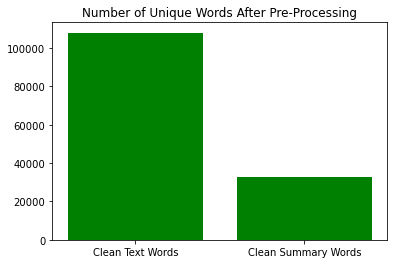

In [88]:
# Store in a dictionary
unique_words = {'Clean Text Words': total_clean_text_words, 
                'Clean Summary Words': total_clean_summary_words}
# Plot as a bar plot 
plt.bar(unique_words.keys(), unique_words.values(), color = 'green')
plt.title('Number of Unique Words After Pre-Processing')
plt.show()

We can see a significant reduction in the number of unique words appearing in our datasets after the pre-processing.  We will now add starting and ending tokens to the summary texts.  This will help our model.

In [89]:
# Add start and end tokens to each summary
df['cleaned_summary'] = df['cleaned_summary'].apply(lambda row: '_START_ ' + row + ' _END_')

We will examine the first 10 rows of our cleaned data.

In [91]:
for row in range(10):
    print('Review Text:', df['cleaned_text'][row])
    print('Summary Text:', df['cleaned_summary'][row])
    print('\n')

Review Text: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary Text: _START_ good quality dog food _END_


Review Text: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary Text: _START_ not as advertised _END_


Review Text: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary Text: _START_ delight says it all _END_


Review Text: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary Text: _START_ cough medicine _END_


Review Text: great taffy great price wide assor

We can see that our data appears as we intnded it.  It is all lowercased, with punctuations, special characters, and non-alphabetic characters all removed.  We will now save our cleaned dataset for use in the next notebook. 

In [92]:
# Save dataframe to CSV
df.to_csv('cleaned_reviews.csv')

### Concluding Thoughts for Notebook 1

Our pre-processing is now complete.  In the next notebook we will build and train our abstractive summarization model.  The first thing we will do is examine the lengths of our reviews and our summaries.  This will allow us to identify an appropriate threshold for the data we will use in our model.

Then, we will build our tokenizers and build and train our model.